<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [1]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.2/273.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━

In [13]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [14]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 27.8MB/s]                   


'atm_daily_cash.csv'

In [15]:
df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Взглянем на то, что представляют из себя данные:

In [16]:
df.head()

,Date,CashIn,CashOut
4,1/5/2016,20840.0,22200.0
5,1/6/2016,28460.0,18810.0
6,1/7/2016,19250.0,23210.0
7,1/8/2016,49770.0,4350.0
8,1/9/2016,NaN,NaN


В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [17]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

In [18]:
import matplotlib.pyplot as plt

In [19]:
df["Date"] = pd.to_datetime(df["Date"])

In [20]:
df.head()

,Date,CashIn,CashOut,target
4,2016-01-05,20840.0,-22200.0,-1360.0
5,2016-01-06,28460.0,-18810.0,9650.0
6,2016-01-07,19250.0,-23210.0,-3960.0
7,2016-01-08,49770.0,-4350.0,45420.0
8,2016-01-09,NaN,NaN,NaN


In [21]:
df.describe()

,CashIn,CashOut,target
count,1081.000000,1094.000000,1072.000000
mean,37261.618871,-30985.648995,5976.651119
std,20583.186636,18314.048275,21551.659802
min,100.000000,-111700.000000,-75190.000000
25%,21690.000000,-40375.000000,-6277.500000
50%,34980.000000,-27895.000000,5320.000000
75%,50280.000000,-18010.000000,18515.000000
max,121300.000000,-0.000000,85160.000000


In [22]:
df.isna().sum() #вроде налов немного забьем на них пока, потом обработаем

Date         0
CashIn     101
CashOut     88
target     110
dtype: int64

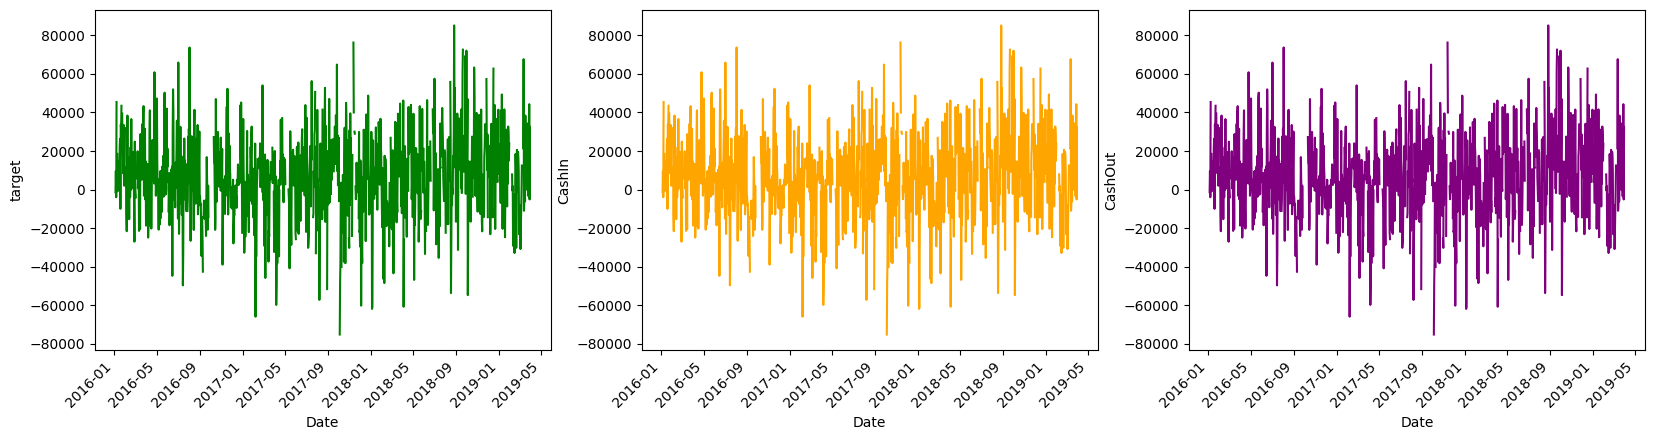

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.autofmt_xdate(rotation=45)

# Creating the sub-plots.
ax1.plot(df.Date, df.target, color='green')
ax1.set_xlabel("Date")
ax1.set_ylabel("target") 

ax2.plot(df.Date, df.target, color='orange')
ax2.set_xlabel("Date")
ax2.set_ylabel("CashIn") 
  
ax3.plot(df.Date, df.target, color='purple')
ax3.set_xlabel("Date")
ax3.set_ylabel("CashOut") 

plt.show()

<Axes: xlabel='Date'>

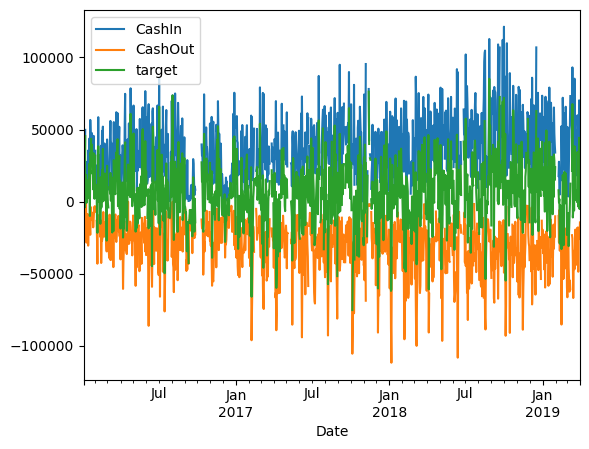

In [24]:
df.plot(x='Date')

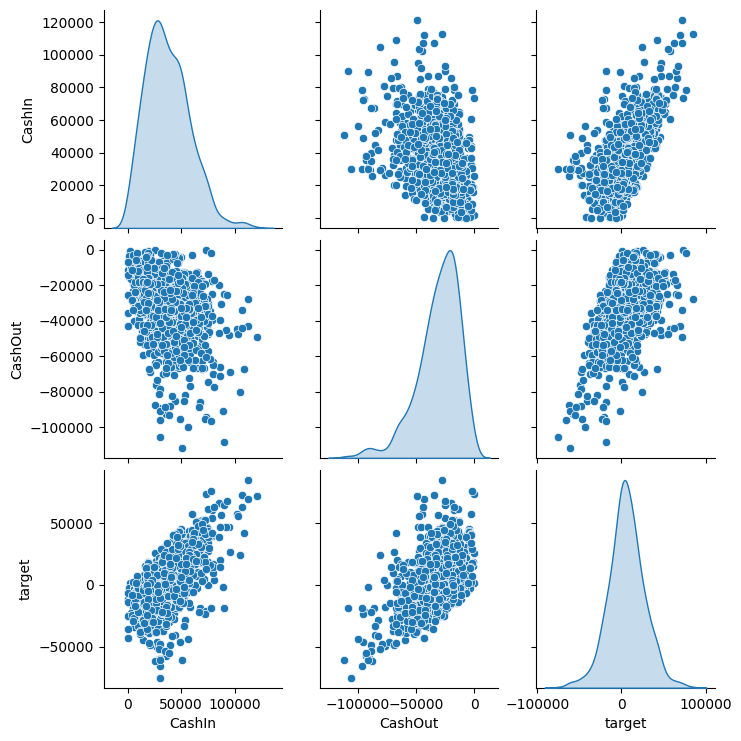

In [25]:
sns.pairplot(df, diag_kind="kde")

<Axes: >

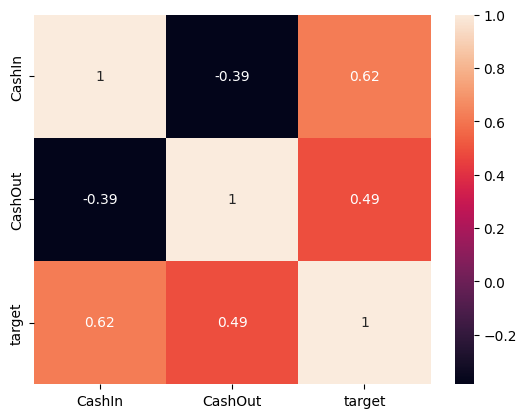

In [26]:
sns.heatmap(df.corr("pearson"), annot=True)

Сложно судить о наличие зависимости, вероятно есть некоторая годовая сезоность, но нужно сделать аггрегацию по месяцам и неделям

<Axes: xlabel='Date'>

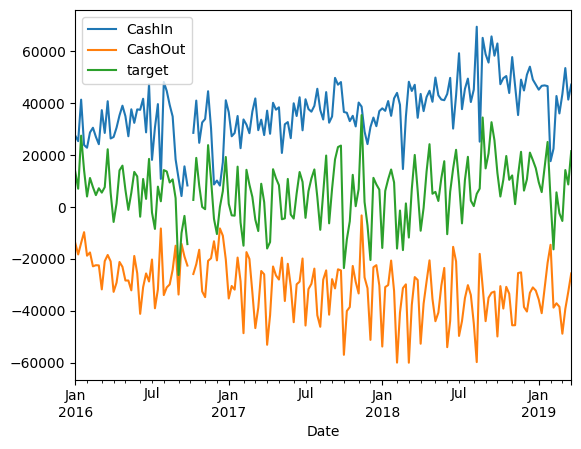

In [27]:
agg_week = df.groupby(by = df['Date'].dt.to_period('W').dt.to_timestamp()).mean().reset_index().sort_values(by='Date')
agg_week.plot(x='Date')

Все еще сложно отследить тренды и сезонность, попробуем сделать приближение

<Axes: xlabel='Date'>

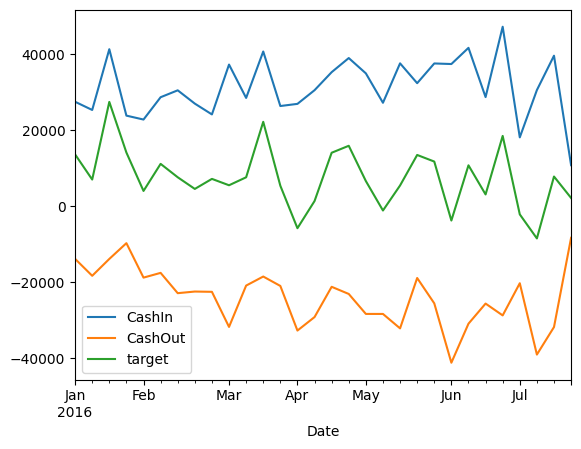

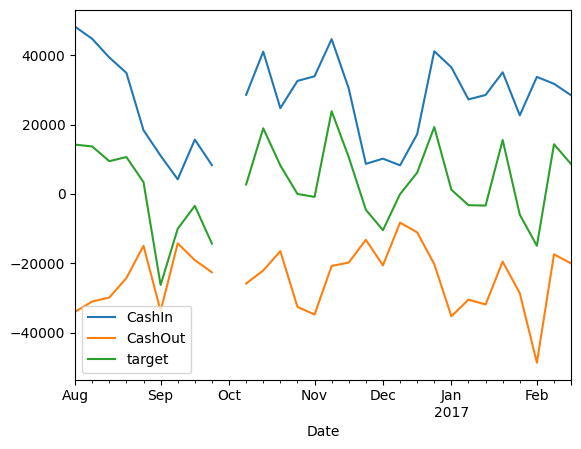

In [28]:
agg_week.iloc[:30,].plot(x='Date')
agg_week.iloc[30:60,].plot(x='Date')

<Axes: xlabel='Date'>

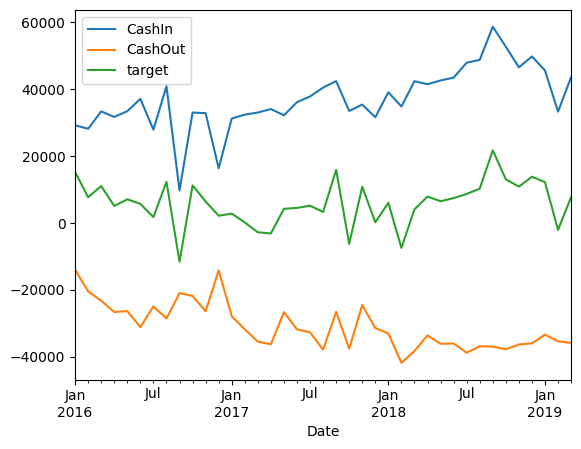

In [29]:
agg_month = df.groupby(by = df['Date'].dt.to_period('M').dt.to_timestamp()).mean().reset_index().sort_values(by='Date')
agg_month.plot(x='Date')

Можно заметить некоторую годовую и меясчную сезонность, но важно помнить, что при аггрегации мы заменяли на среднее значение, поэтому давайте поймем какой вообще разброс наших значений в зависимости от месяца и недели

In [30]:
df_copy = df.copy()

<Axes: xlabel='week_day', ylabel='target'>

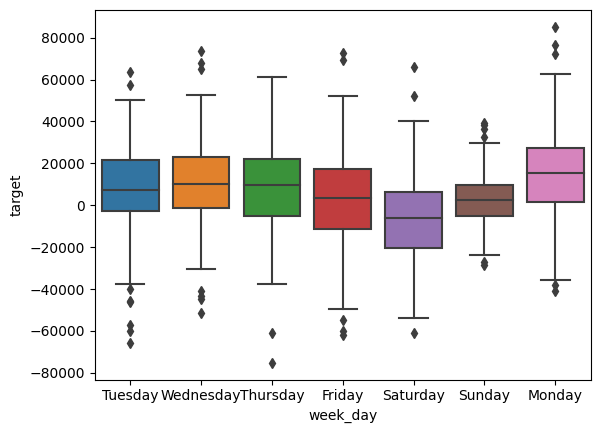

In [31]:
df_copy['week_day'] = df_copy['Date'].dt.day_name()
sns.boxplot(data = df_copy, x = 'week_day', y = 'target')

<Axes: xlabel='month', ylabel='target'>

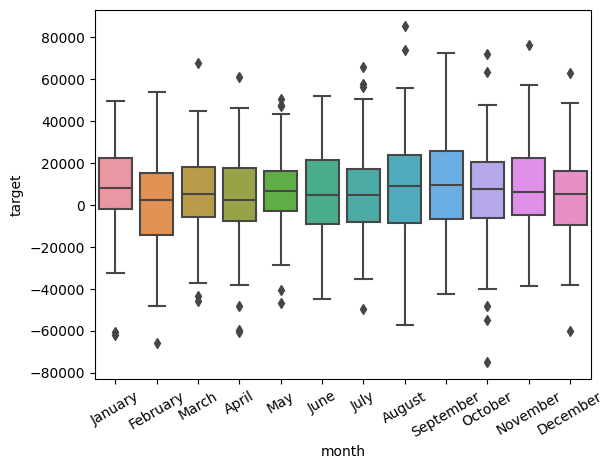

In [32]:
df_copy['month'] = df_copy['Date'].dt.month_name()
ax = sns.boxplot(x='month', y='target', data=df_copy)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [34]:
from etna.datasets import TSDataset

In [35]:
ms = df.copy()

In [36]:
# перемименуем колоночку]б чтобы не путать таргет в TSDataset и название сегмента
ms.rename(columns={"target": "CashDiff"}, inplace=True)

In [37]:
ms.head()

,Date,CashIn,CashOut,CashDiff
4,2016-01-05,20840.0,-22200.0,-1360.0
5,2016-01-06,28460.0,-18810.0,9650.0
6,2016-01-07,19250.0,-23210.0,-3960.0
7,2016-01-08,49770.0,-4350.0,45420.0
8,2016-01-09,NaN,NaN,NaN


In [38]:
ms = pd.melt(ms, id_vars=['Date'], value_vars=['CashIn', 'CashOut', 'CashDiff'])
ms.head()

,Date,variable,value
0,2016-01-05,CashIn,20840.0
1,2016-01-06,CashIn,28460.0
2,2016-01-07,CashIn,19250.0
3,2016-01-08,CashIn,49770.0
4,2016-01-09,CashIn,NaN


In [39]:
ms.rename(columns={"Date": "timestamp", "variable": "segment", "value": "target"}, inplace=True)

In [40]:
ms.head()

,timestamp,segment,target
0,2016-01-05,CashIn,20840.0
1,2016-01-06,CashIn,28460.0
2,2016-01-07,CashIn,19250.0
3,2016-01-08,CashIn,49770.0
4,2016-01-09,CashIn,NaN


In [41]:
tsms = TSDataset.to_dataset(ms)
tsms.head()

segment,CashDiff,CashIn,CashOut
feature,target,target,target
timestamp,,,
2016-01-05,-1360.0,20840.0,-22200.0
2016-01-06,9650.0,28460.0,-18810.0
2016-01-07,-3960.0,19250.0,-23210.0
2016-01-08,45420.0,49770.0,-4350.0
2016-01-09,NaN,NaN,NaN


In [42]:
# то есть измерения происходили каждый день
ts = TSDataset(tsms, freq="D")

In [43]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
CashDiff,2016-01-05,2019-03-31,1182,110,3,0,0,0,D
CashIn,2016-01-05,2019-03-31,1182,101,3,0,0,0,D
CashOut,2016-01-05,2019-03-31,1182,88,3,0,0,0,D


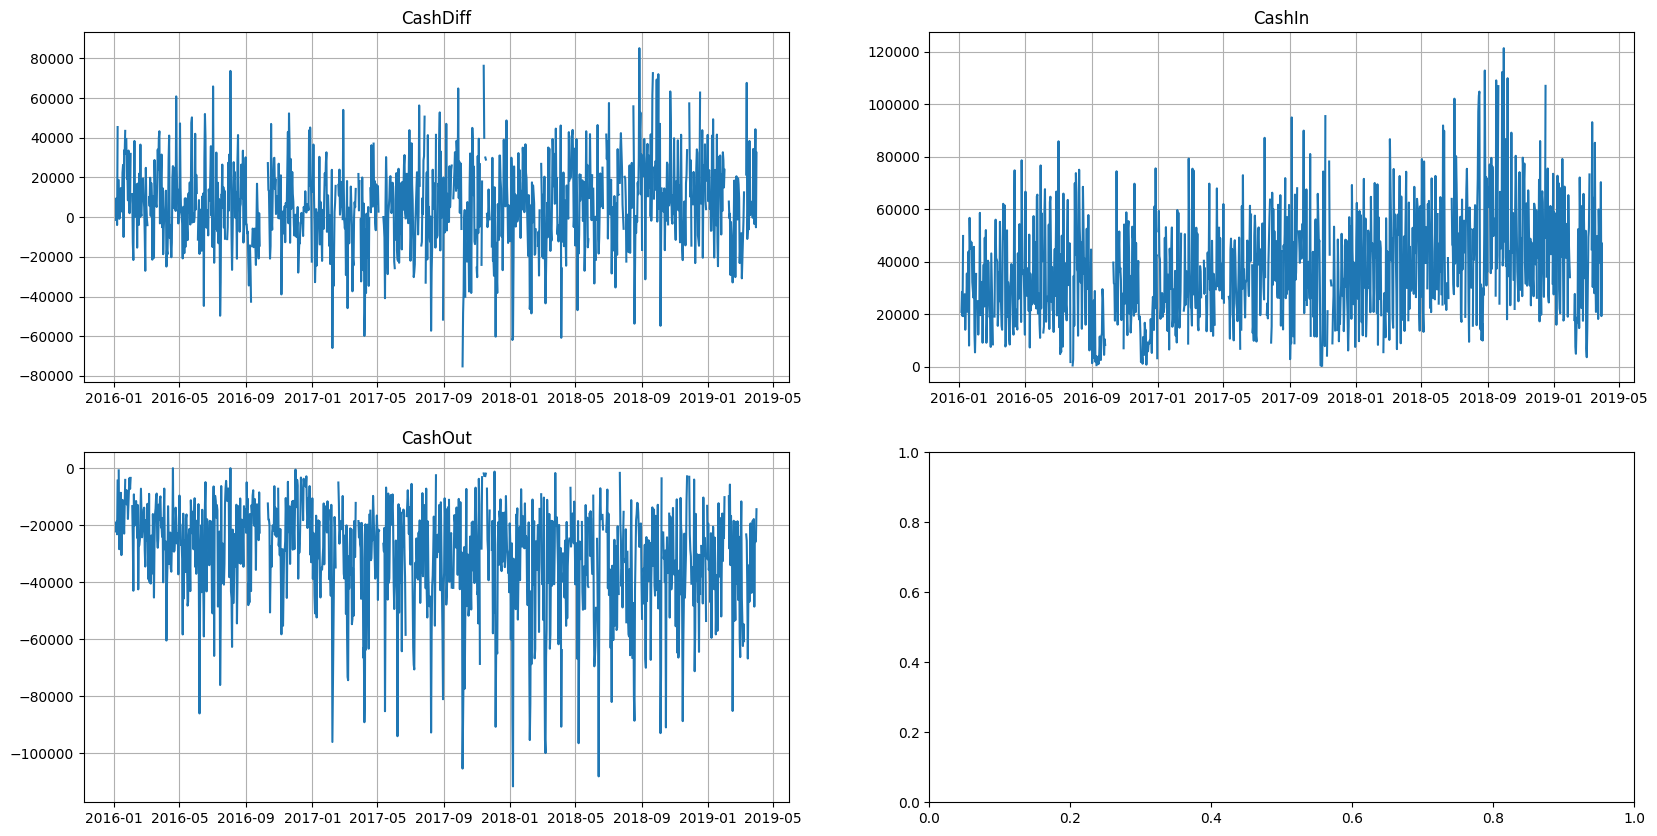

In [44]:
ts.plot()

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

Мы видели, что данные очень сложные и в них много паттернов, поэтому сложно однозначно сказать, как правильно заполнить пропуски, особенно те, в которых не хватает несколько дней. При этом кажется, что просто удаление может сильно испортить модель. Какие вообще есть стандартные методы заполнения пропусков?

If “mean”, then replace missing dates using the mean in fit stage.

If “running_mean” then replace missing dates using mean of subset of data

If “forward_fill” then replace missing dates using last existing value

If “seasonal” then replace missing dates using seasonal moving average

If “constant” then replace missing dates using constant value.

Мы хотим избежать одинаковых значений в соседние дни, поэтому наиболее подходящим кажется сезонность и скользящее среднее.  Но вот сезонность это не очень надежно, может быть меного изменений в конкретный день или месяц, Поэтому остановимся на скользящем среднем.

In [45]:
from etna.transforms import TimeSeriesImputerTransform
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast,
                           sample_acf_plot, sample_pacf_plot)
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform)

In [46]:
missing = TimeSeriesImputerTransform(strategy="running_mean", window=30)
ts.fit_transform([missing])
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
CashDiff,2016-01-05,2019-03-31,1182,0,3,0,0,0,D
CashIn,2016-01-05,2019-03-31,1182,0,3,0,0,0,D
CashOut,2016-01-05,2019-03-31,1182,0,3,0,0,0,D


In [47]:
ts

segment,CashDiff,CashIn,CashOut
feature,target,target,target
timestamp,,,
2016-01-05,-1360.0,20840.0,-22200.0
2016-01-06,9650.0,28460.0,-18810.0
2016-01-07,-3960.0,19250.0,-23210.0
2016-01-08,45420.0,49770.0,-4350.0
2016-01-09,12437.5,29580.0,-17142.5
...,...,...,...
2019-03-27,-3440.0,45160.0,-48600.0
2019-03-28,16640.0,39480.0,-22840.0


Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

### Отклонение от медианных значений рассчитанных по окну

Воспользуемся интерактивной визуализацией

In [48]:
segmnets = ['CashDiff', 'CashIn', 'CashOut']

for segment in segmnets:
    method = get_anomalies_median
    params_bounds = {"window_size": (40, 100, 1), "alpha": (0.1, 4, 0.25)}
    print(segment)
    plot_anomalies_interactive(
        ts=ts, segment=segment, method=method, params_bounds=params_bounds
    )

CashDiff


interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', min=40, style=Sl…

CashIn


interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', min=40, style=Sl…

CashOut


interactive(children=(IntSlider(value=40, continuous_update=False, description='window_size', min=40, style=Sl…

Кажкется, в ноутбуке интерактивная визуализация не сохраняется, но можно перезапустить :)
    
Вообще для разных сегментов можно были выбирать разные параметры для аутлаеров, но мне визуально показалось, что для всех подходит window_size = 65, alpha = 2.6
 

Стоит отметить, что часть аутлаеров выглядит скорее как проявление некоторой сезонности и возможно есть смысл обучать модельку и без удаления выбросов

In [49]:
best_params = {"window_size": 65, "alpha": 2.6}

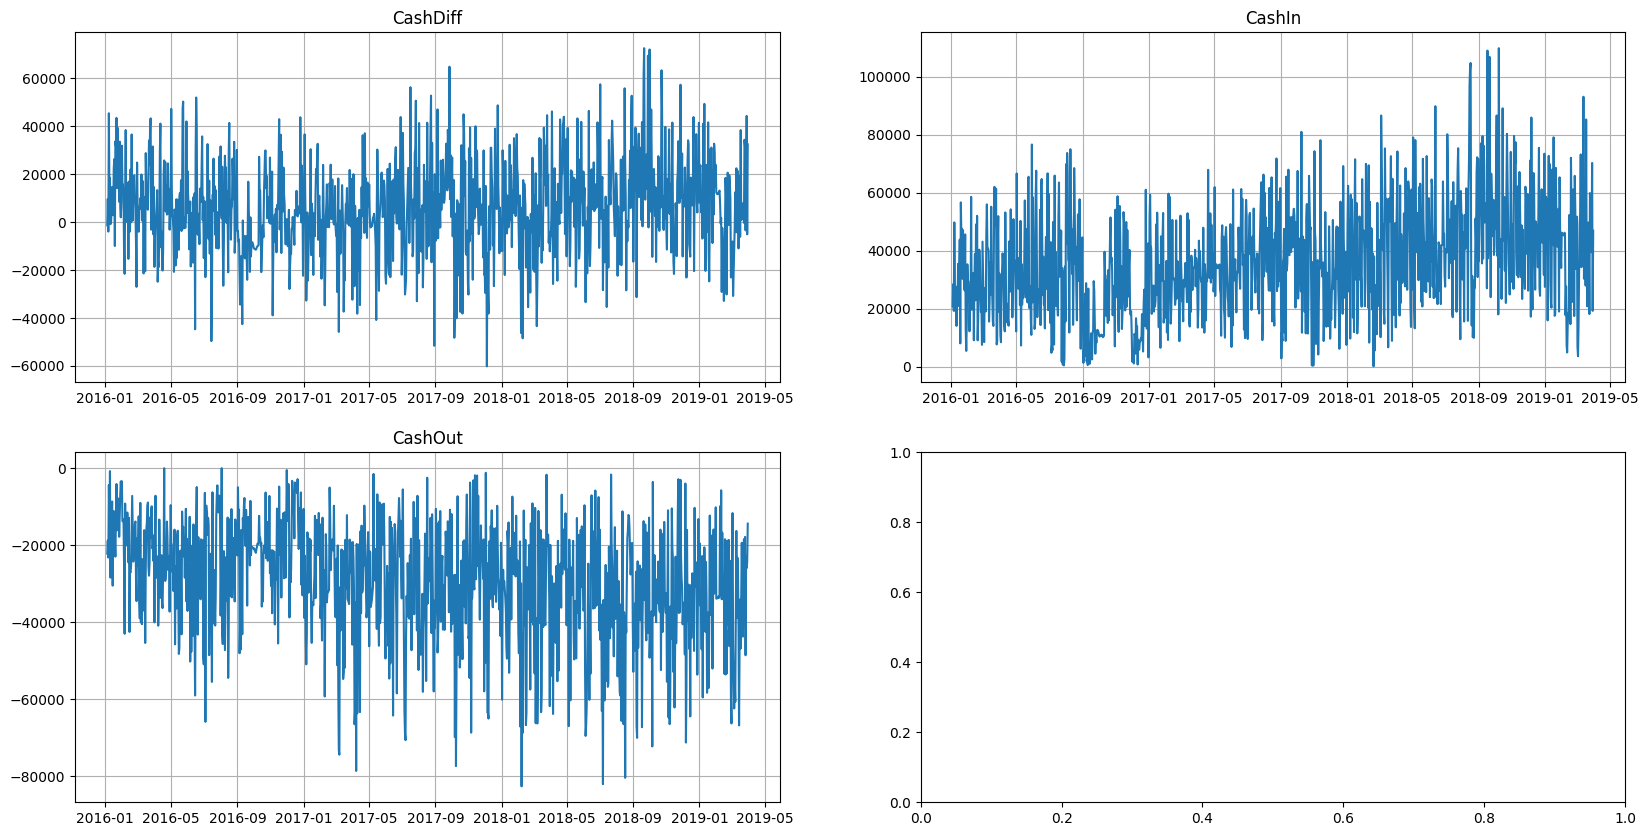

In [50]:
# Impute outliers with NaNs
outliers_remover = MedianOutliersTransform(in_column='target', **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=30
)
ts.fit_transform([outliers_remover, outliers_imputer])
ts.plot()

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [51]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [52]:
HORIZON = 5

In [53]:
model = ProphetModel()  
transforms = []  # пока оставим пустым
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON) 

In [58]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp70357fo5/4s4ylgxn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp70357fo5/zmj0nsae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35040', 'data', 'file=/tmp/tmp70357fo5/4s4ylgxn.json', 'init=/tmp/tmp70357fo5/zmj0nsae.json', 'output', 'file=/tmp/tmpvw7zv_dl/prophet_model-20230518192514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [59]:
metrics_df

,segment,MAE,SMAPE
0,CashDiff,14075.246103,136.084507
1,CashIn,15246.966178,33.058728
2,CashOut,11959.366716,35.267762


In [61]:
fold_info_df

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,2016-01-05,2019-03-06,2019-03-07,2019-03-11,0
0,2016-01-05,2019-03-11,2019-03-12,2019-03-16,1
0,2016-01-05,2019-03-16,2019-03-17,2019-03-21,2
0,2016-01-05,2019-03-21,2019-03-22,2019-03-26,3
0,2016-01-05,2019-03-26,2019-03-27,2019-03-31,4


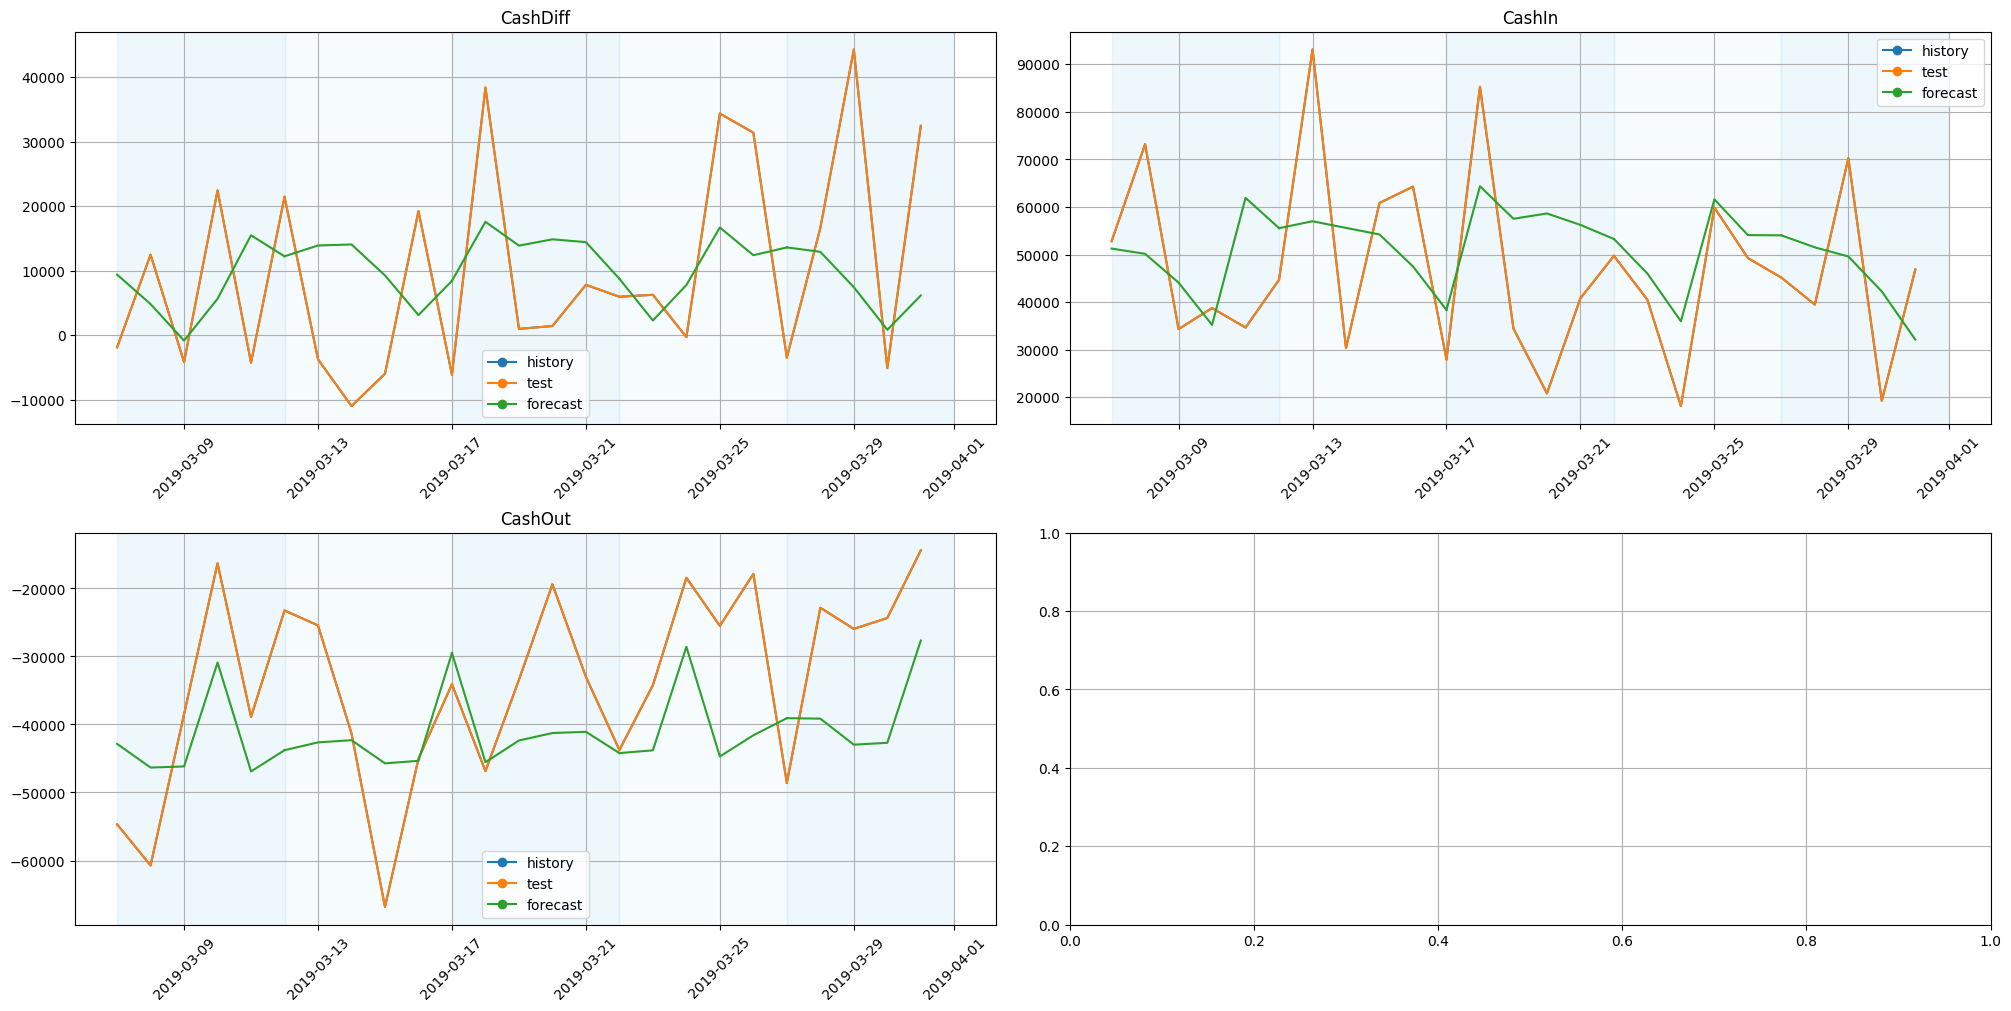

In [62]:
plot_backtest(forecast_df, ts)

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

Предикт, конечно, грустно выглядит, определенно нудны дополнительные преобразования. Но вообще CasgIn и CashOut предсказываются лучше, чем их разница (зависимая переменная). Возможно стоит попробовать предсказывать только их, а потом уже вычислять таргет.

 MAE посчитано в предыдущем блоке, для него все аналогично

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [63]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [85]:
# для этого блока заново подготовим датасет

hierarchical_df = df.copy()
hierarchical_df.rename(columns={"target": "CashDiff"}, inplace=True)
hierarchical_df = pd.melt(hierarchical_df, id_vars=['Date'], value_vars=['CashIn', 'CashOut'])
hierarchical_df.rename(columns={"Date": "timestamp", "variable": "segment", "value": "target"}, inplace=True)

In [86]:
hierarchical_df

,timestamp,segment,target
0,2016-01-05,CashIn,20840.0
1,2016-01-06,CashIn,28460.0
2,2016-01-07,CashIn,19250.0
3,2016-01-08,CashIn,49770.0
4,2016-01-09,CashIn,NaN
...,...,...,...
2359,2019-03-27,CashOut,-48600.0
2360,2019-03-28,CashOut,-22840.0
2361,2019-03-29,CashOut,-25950.0
2362,2019-03-30,CashOut,-24350.0


In [87]:
hierarchical_df = TSDataset.to_dataset(df=hierarchical_df)

In [88]:
# задаем то, как соотносятся сегменты между собой
hierarchical_structure = HierarchicalStructure(
    level_structure={"CashDiff": ["CashIn", "CashOut"]}, level_names=["Diff", "Common"]
)

In [89]:
# создаем иерархический датасет
hierarchical_ts = TSDataset(df=hierarchical_df, freq="D", hierarchical_structure=hierarchical_structure)

hierarchical_ts.head()

segment,CashIn,CashOut
feature,target,target
timestamp,,
2016-01-05,20840.0,-22200.0
2016-01-06,28460.0,-18810.0
2016-01-07,19250.0,-23210.0
2016-01-08,49770.0,-4350.0
2016-01-09,NaN,NaN


In [90]:
# текущий уровень
hierarchical_ts.current_df_level

'Common'

In [91]:
# уровень выше
hierarchical_ts.get_level_dataset(target_level="Diff").head()

segment,CashDiff
feature,target
timestamp,
2016-01-05,-1360.0
2016-01-06,9650.0
2016-01-07,-3960.0
2016-01-08,45420.0
2016-01-09,NaN


In [92]:
reconciliator = BottomUpReconciliator(target_level="Diff", source_level="Common")

In [93]:
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]], dtype=int32)

In [94]:
reconciliator.aggregate(ts=hierarchical_ts).head()

segment,CashIn,CashOut
feature,target,target
timestamp,,
2016-01-05,20840.0,-22200.0
2016-01-06,28460.0,-18810.0
2016-01-07,19250.0,-23210.0
2016-01-08,49770.0,-4350.0
2016-01-09,NaN,NaN


Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

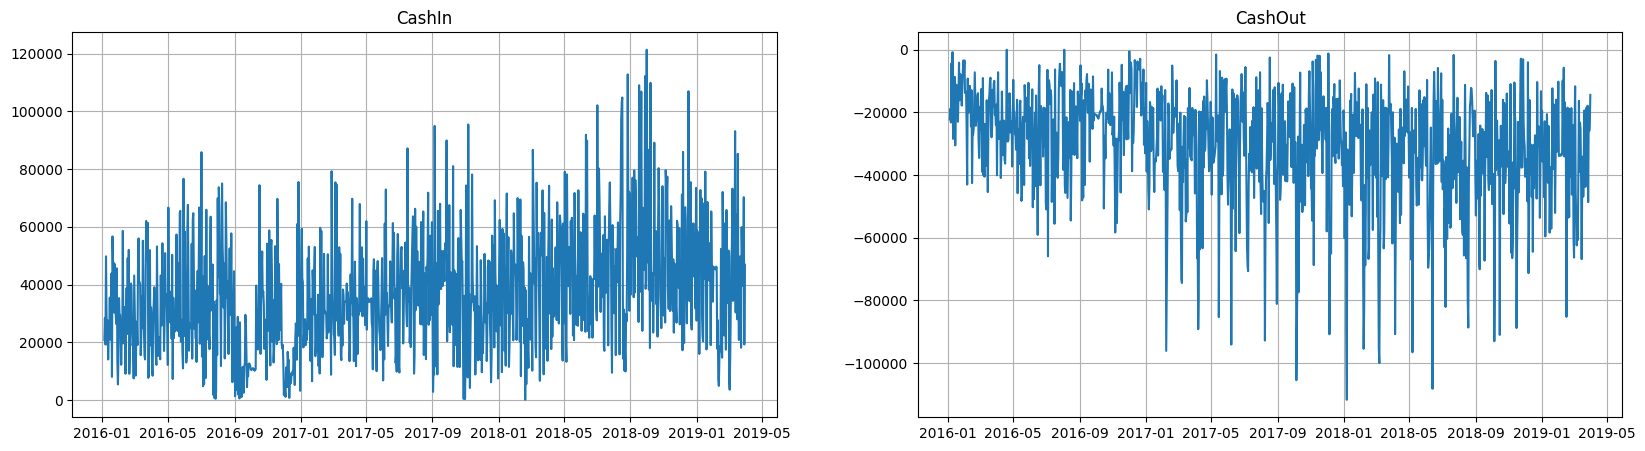

In [95]:
outliers_remover = MedianOutliersTransform(in_column='target', **best_params)
# Impute NaNs using the specified strategy
outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy="running_mean", window=30
)
hierarchical_ts.fit_transform([outliers_remover, outliers_imputer])
hierarchical_ts.plot()

In [101]:
pipeline = HierarchicalPipeline(
    model=ProphetModel(),
    reconciliator=reconciliator,
    horizon = HORIZON
)

bottom_up_metrics, _, _ = pipeline.backtest(ts=hierarchical_ts, metrics=[SMAPE(), MAE()], n_folds=3, aggregate_metrics=True)
bottom_up_metrics = bottom_up_metrics.set_index("segment").add_suffix("_bottom_up")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp70357fo5/o0d5rsio.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp70357fo5/pteflkrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33523', 'data', 'file=/tmp/tmp70357fo5/o0d5rsio.json', 'init=/tmp/tmp70357fo5/pteflkrx.json', 'output', 'file=/tmp/tmpyaxb29nl/prophet_model-20230518200335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:03:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:03:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [102]:
bottom_up_metrics

,SMAPE_bottom_up,MAE_bottom_up
segment,,
CashDiff,122.289542,14151.736986


До этого SMAPE было 136, то есть мы немного улучшились

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [103]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

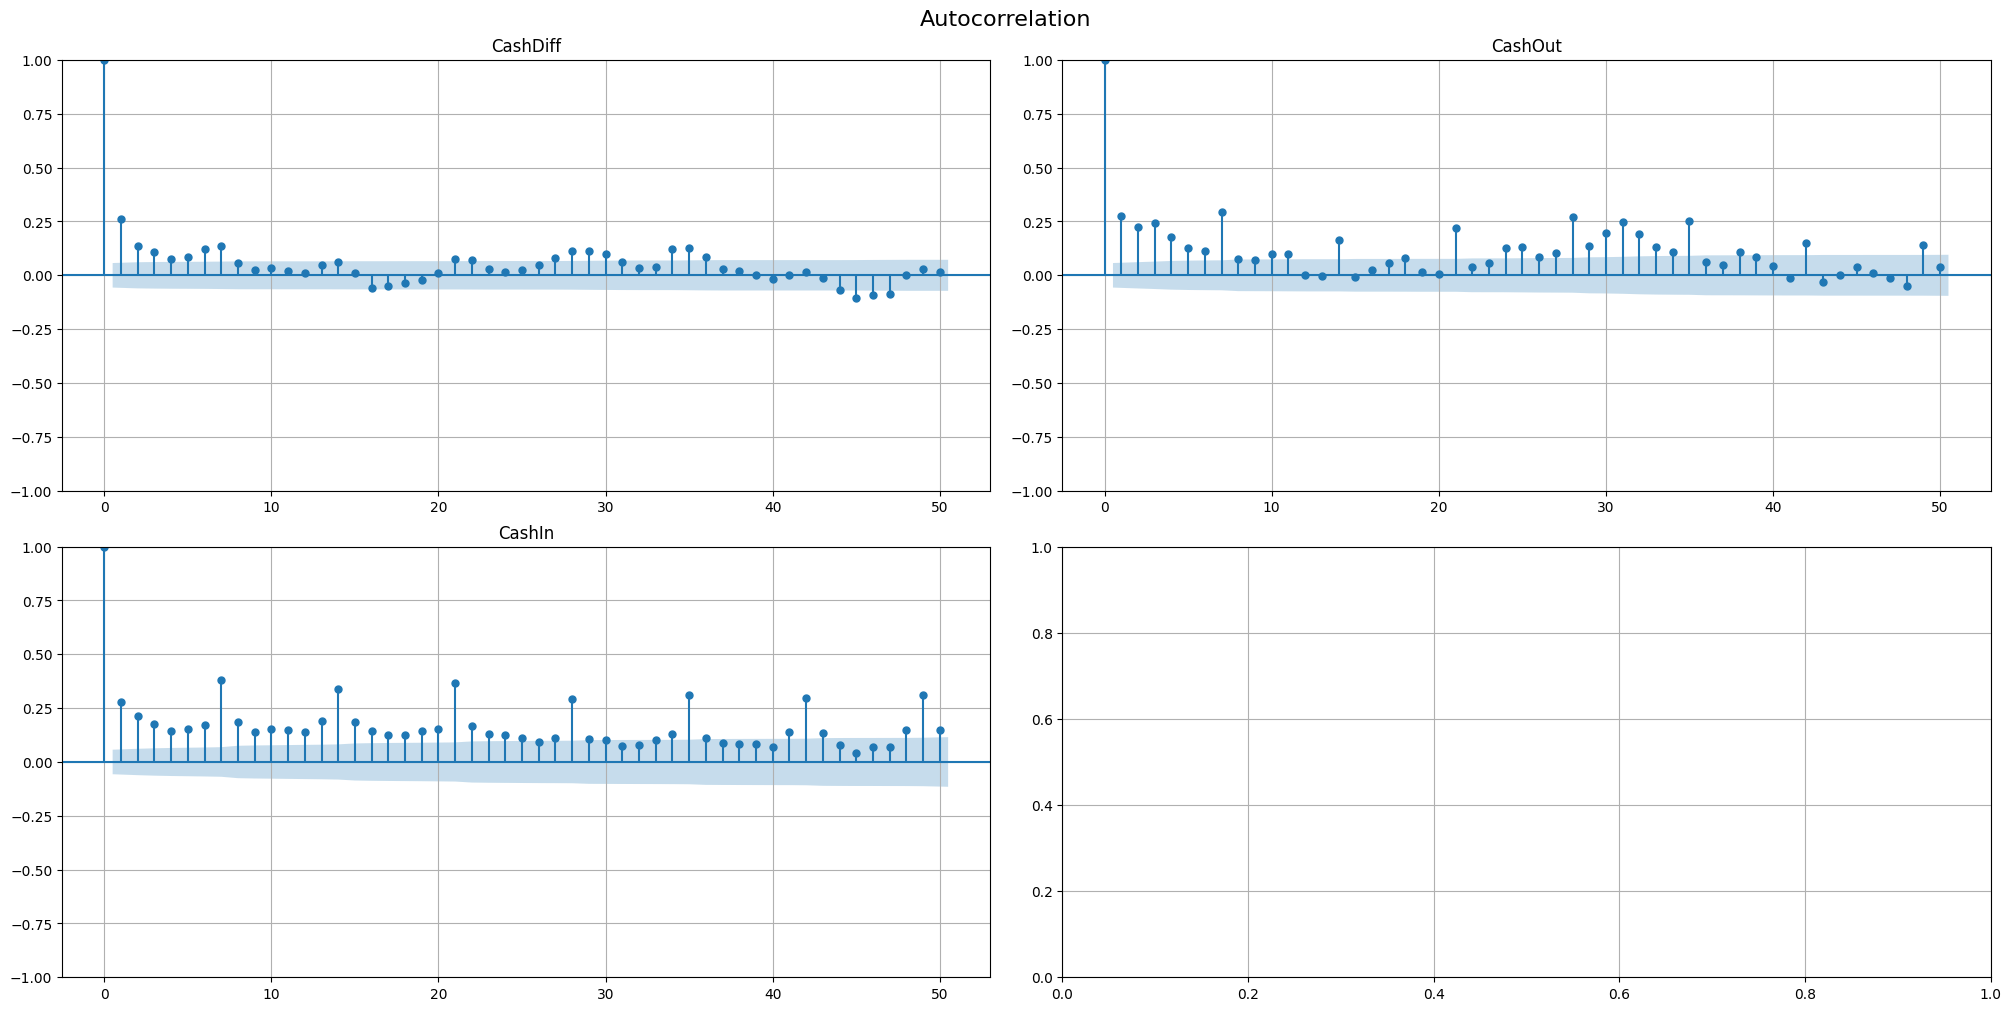

In [106]:
sample_acf_plot(ts, lags=50)

Везде хорошая корреляция на 2 и 7 день, соответсвенно возьме их как лаги. Вообще вся первая неделя неплохие показатели дает. При этом в CashIn каждый чедьмой день сильный рост корреляции, там определенно есть сезонность. 

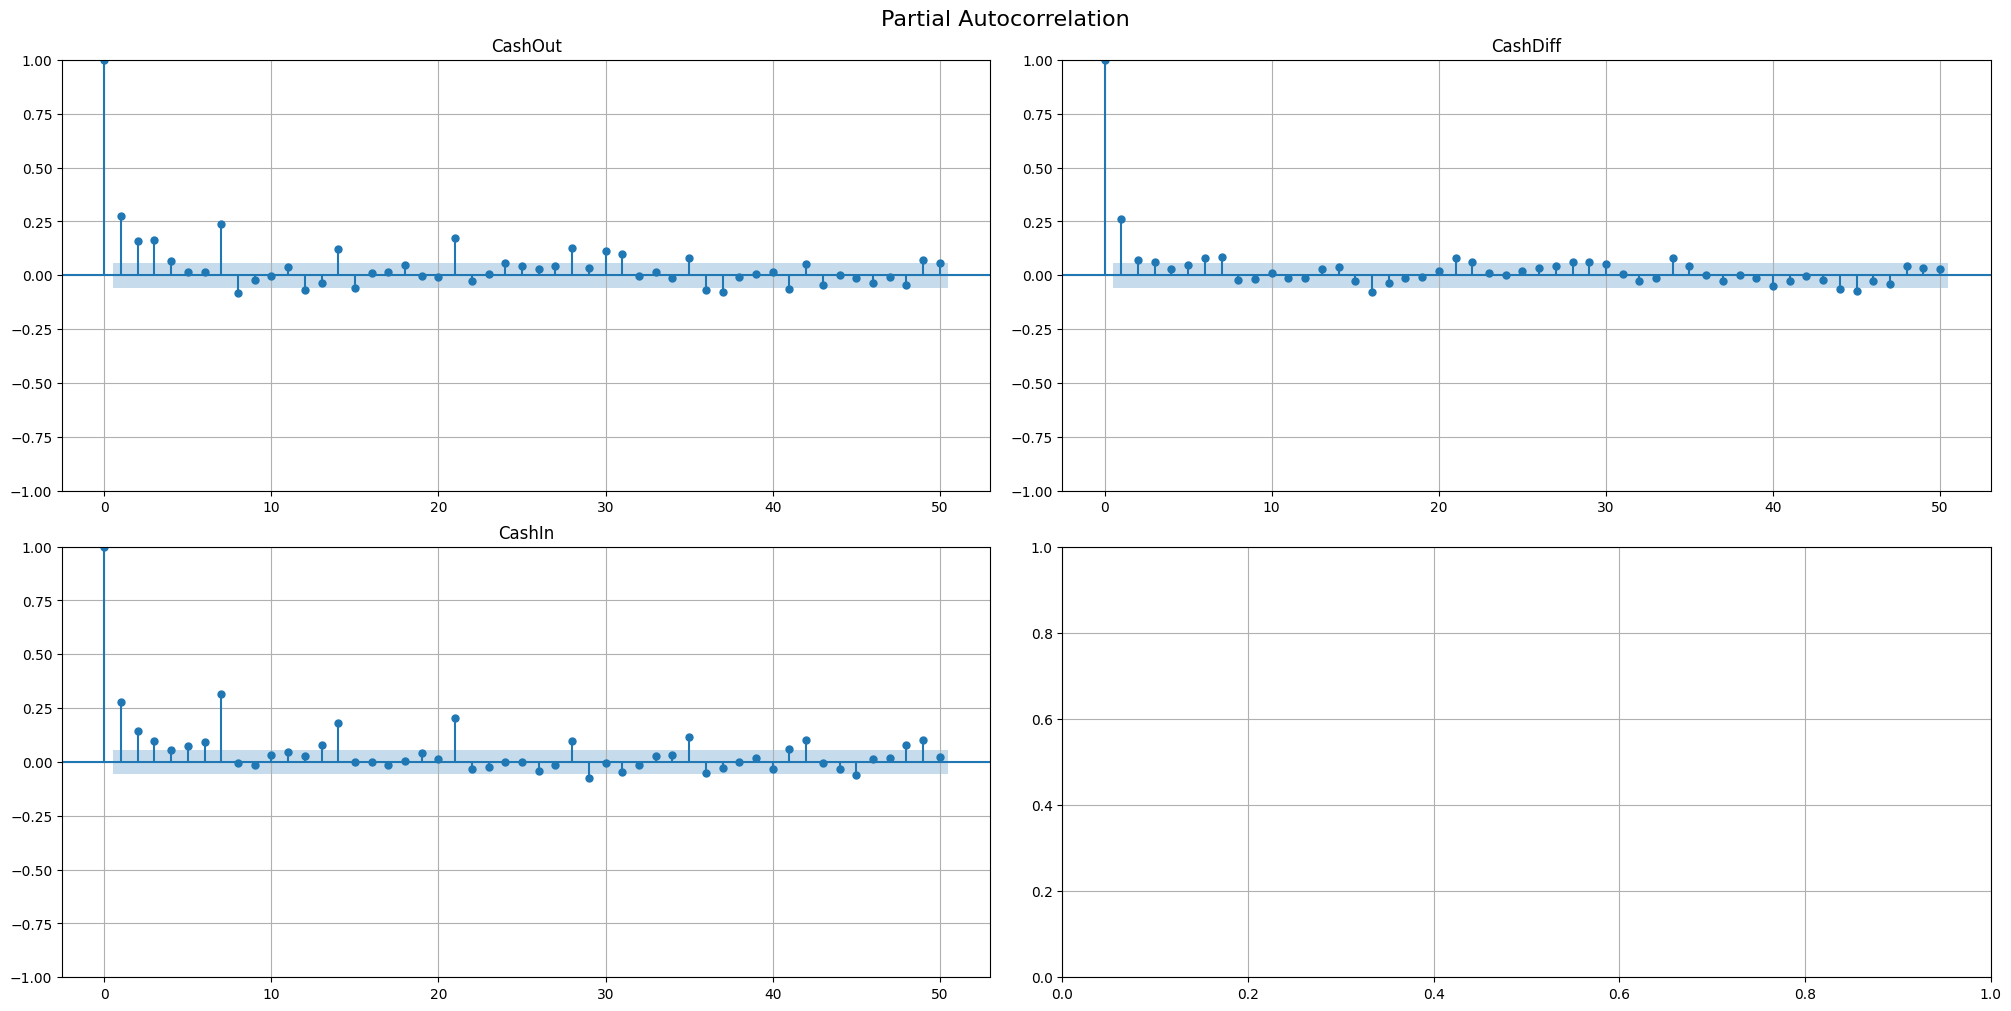

In [107]:
sample_pacf_plot(ts, lags=50)

Для CashIn снова видим каждый седьмой день, для  CashOut и CashDiff первая неделя

In [108]:
# вспомним, что пропуски и аутлаеры мы уже обработали
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 3
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: D
         start_timestamp end_timestamp  length  num_missing
segments                                                   
CashDiff      2016-01-05    2019-03-31    1182            0
CashIn        2016-01-05    2019-03-31    1182            0
CashOut       2016-01-05    2019-03-31    1182            0


In [122]:
pipeline = Pipeline(
    transforms=[
        LagTransform(in_column="target", lags=list(range(1, 7, 1)) + [14, 21], out_column="target_lag"),
        DateFlagsTransform(
          day_number_in_week=True, # видели в первом задании, что день недели влияет
          month_number_in_year=True, # учтем также номер месяца. НапримерБ перед новым годом поток денежек должен быть больше
          year_number=True, out_column="date_transform"),
        STLTransform(in_column="target", period=7, model="arima"), # добавление STL декомпозиции
        HolidayTransform(iso_code="TR", out_column="TR_holidays"), # в праздники много денег тратят
        MeanTransform(in_column="target", window=30) # и попробуем добавить аггрегированный признак
    ],
    model=CatBoostMultiSegmentModel(),
    horizon=HORIZON
)
metrics, forecast, _ = pipeline.backtest(
    ts=ts, metrics=[MAE(), SMAPE()], aggregate_metrics=True
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   56.4s finished


In [123]:
metrics

,segment,MAE,SMAPE
0,CashDiff,33351.164993,140.093203
1,CashIn,32128.479097,54.162856
2,CashOut,14554.347529,66.065889


Чет как-то грустно ему, но лучше признаки у меня не получилось подобрать))

И дальше я не успела...

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#